In [2]:
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))


import importlib, numpy as np
from sys import path
import time, os, copy

from sunpy.map import Map
from sunpy.net import Fido, vso, attrs as a
from sunpy.time import TimeRange
from ndcube import NDCube, NDCubeSequence, NDCollection
from astropy import wcs

import astropy.units as u
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18}) # Make the fonts in figures big enough for papers
plt.rcParams.update({'figure.figsize':[27,15]})
plt.rcParams.update({'image.origin':'lower'})
np.set_printoptions(linewidth=128)

base_path = './' #os.getcwd()

# Import EMToolKit and its visualization module
import EMToolKit.EMToolKit as emtk
import EMToolKit
import EMToolKit.visualization
from EMToolKit.visualization.dashboard import dashboard_object
from EMToolKit.instruments.aia import load_from_paths, aia_wrapper
from EMToolKit.algorithms.sparse_em_wrapper import sparse_em_wrapper
from EMToolKit.algorithms.simple_reg_dem_wrapper import simple_reg_dem_wrapper
from EMToolKit.algorithms.sparse_nlmap_dem_wrapper import sparse_nlmap_dem_wrapper

# Reload EMToolKit modules to ensure the latest version is used
importlib.reload(EMToolKit)
importlib.reload(EMToolKit.visualization)

# Initialize an empty EM collection
em_collection = 0

redownload=False

In [3]:
daystr = '2010_07_25_17_58_44'
date='2010/07/25 17:58:44'
data_path = os.path.join(base_path,'data',daystr)

xl, yl, dx, dy = 240*u.arcsec, -525*u.arcsec, 270*u.arcsec, 240*u.arcsec
#xl, yl, dx, dy = 240*u.arcsec, -525*u.arcsec, 135*u.arcsec, 120*u.arcsec

# Commands for initial data download. Comment out once that's successful.
# VSO can sometimes be a bit flakey here, in my experience, may require multiple tries:
#paths = []
#passbands = np.array([94,131,171,193,211,335])*u.angstrom
#for band in passbands: 
#    qry = Fido.search(a.Time(TimeRange(date,12*u.s)),a.Instrument('AIA'),a.Wavelength(band))[0,0]
#    paths.append(Fido.fetch(qry,path=data_path))

aia94dat_path = os.path.join(data_path,'aia_lev1_94a_2010_07_25t17_58_44_13z_image_lev1.fits')
aia131dat_path = os.path.join(data_path,'aia_lev1_131a_2010_07_25t17_58_45_62z_image_lev1.fits')
aia171dat_path = os.path.join(data_path,'aia_lev1_171a_2010_07_25t17_58_48_34z_image_lev1.fits')
aia193dat_path = os.path.join(data_path,'aia_lev1_193a_2010_07_25t17_58_55_84z_image_lev1.fits')
aia211dat_path = os.path.join(data_path,'aia_lev1_211a_2010_07_25t17_58_48_62z_image_lev1.fits')
aia335dat_path = os.path.join(data_path,'aia_lev1_335a_2010_07_25t17_58_51_62z_image_lev1.fits')

# Hinode data was downloaded directly rather than using Fido since I had trouble getting it the latter way:
hinode_path = os.path.join(data_path,'XRT20100725_175844.2.fits')

paths = [aia94dat_path, aia131dat_path, aia171dat_path, aia193dat_path, aia211dat_path, aia335dat_path, hinode_path]
channel_names = np.array(['AIA94_THIN', 'AIA131_THIN', 'AIA171_THIN', 'AIA193_THIN', 'AIA211_THIN', 'AIA335_THIN', 'XRT'])

In [5]:
#from EMToolKit.instruments.aia import download_sdo_data
#from EMToolKit.instruments.xrt import download_xrt_data
from EMToolKit.instruments.aia import load_from_paths, aia_wrapper
from EMToolKit.instruments.xrt import xrt_wrapper

date='2010/07/25 17:58:44'

# Download the data
#aia_paths, sdo_data_dir = download_sdo_data(base_path, date, redownload=redownload)
#xrt_paths, xrt_data_dir = download_xrt_data(base_path, date, redownload=redownload)
#paths = aia_paths + xrt_paths
aia_paths = paths[0:6]
xrt_paths = paths[6]

'.'

In [6]:
# Load the AIA Images ###
aiamaps = load_from_paths(aia_paths,xl=xl,yl=yl,dx=dx,dy=dy)

temperature_array = np.arange(5.5, 7.25, 0.05)

[maps,errs,trlogts,tresps] = aia_wrapper(aiamaps, temperature_array=temperature_array)

xrt_offsets = [-5*u.arcsec, -20*u.arcsec]
xrtmap = load_from_paths([[paths[0]],xrt_paths],xl=xl+xrt_offsets[0],yl=yl+xrt_offsets[1],dx=dx,dy=dy)[1]

2024-11-27 17:07:45 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs,dsun_obs
For frame 'heliographic_stonyhurst' the following metadata is missing: solar_b0,dsun_obs
 [sunpy.map.mapbase]
2024-11-27 17:07:45 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs,dsun_obs
For frame 'heliographic_stonyhurst' the following metadata is missing: solar_b0,dsun_obs



INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


MAP FILTER IS :  Ti_poly


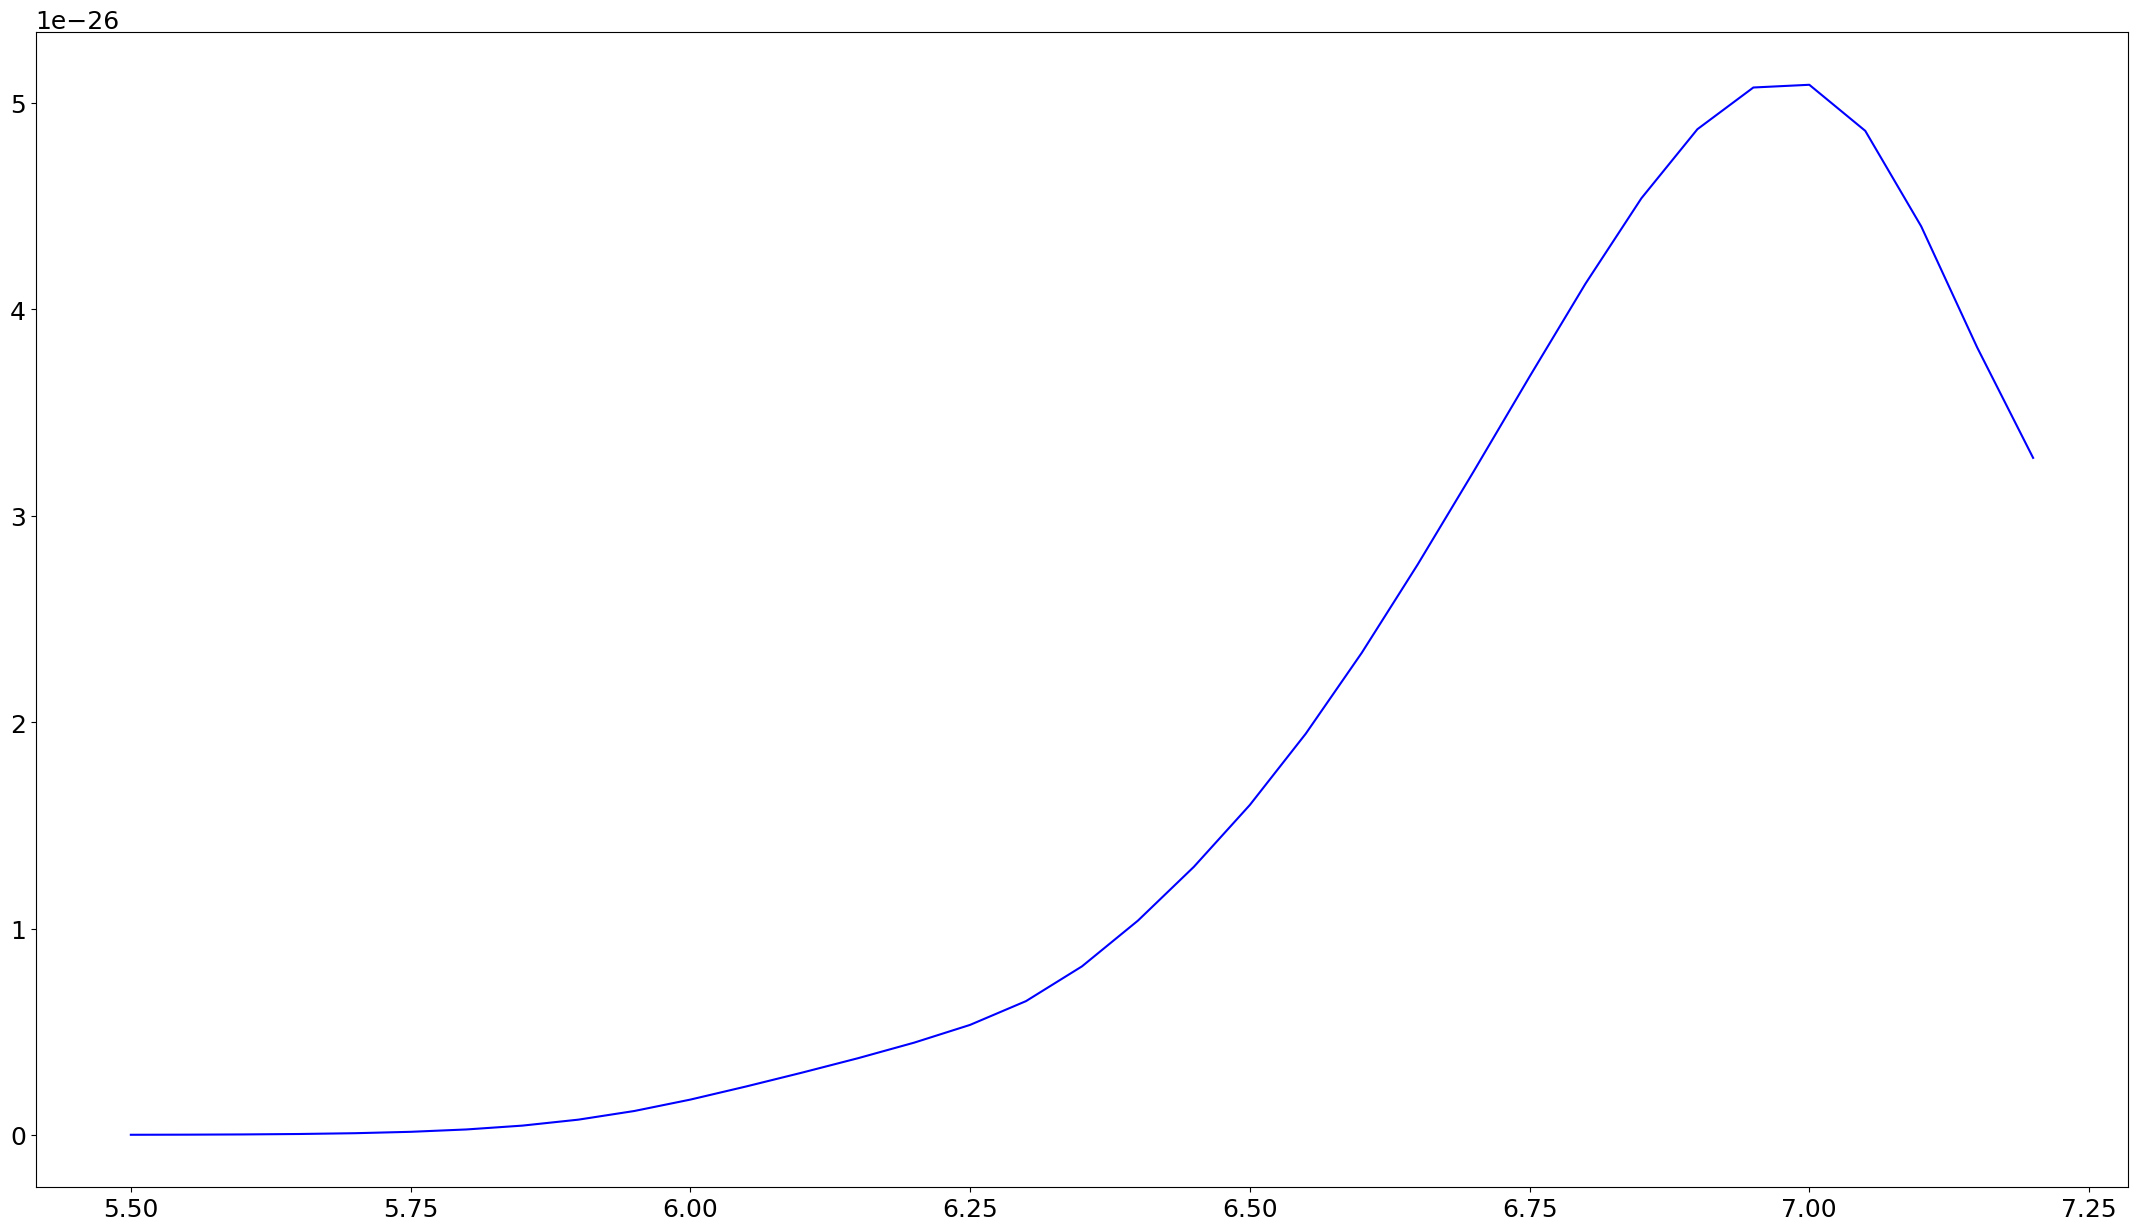

35 35
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [7]:
# Load the XRT Image ###
# We're loading these separately so that we can apply an offset to the XRT data -- there appears
# to be a significant misalignment based on manual inspection and testing:
xrtmap.meta['crval1'] -= xrt_offsets[0].value
xrtmap.meta['crval2'] -= xrt_offsets[1].value
[xrtmaps,xrterrs,xrt_trlogts,xrt_tresps] = xrt_wrapper([xrtmap], temperature_array=temperature_array)
# Append the XRT data to the AIA data
maps.append(xrtmaps[0])
errs.append(xrterrs[0])
trlogts.append(xrt_trlogts[0])
tresps.append(xrt_tresps[0])

In [8]:
# Normalizing the response functions makes them much easier for the solver to handle.
datmax_nominal = 1.0e4 # The nominal maximum of the data 
overall_norm = datmax_nominal/np.max(np.array(tresps))
norms = np.max(np.array(tresps),axis=0)/np.max(np.array(tresps))/overall_norm

In [9]:
# Make data sequence from AIA data:
datasequence = emtk.em_data(maps,errs,trlogts,tresps)

# Create em_collection with AIA data:
em_collection = emtk.em_collection(datasequence)

2024-11-27 17:07:45 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs,dsun_obs
For frame 'heliographic_stonyhurst' the following metadata is missing: solar_b0,dsun_obs
 [sunpy.map.mapbase]
2024-11-27 17:07:45 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs,dsun_obs
For frame 'heliographic_stonyhurst' the following metadata is missing: solar_b0,dsun_obs



INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


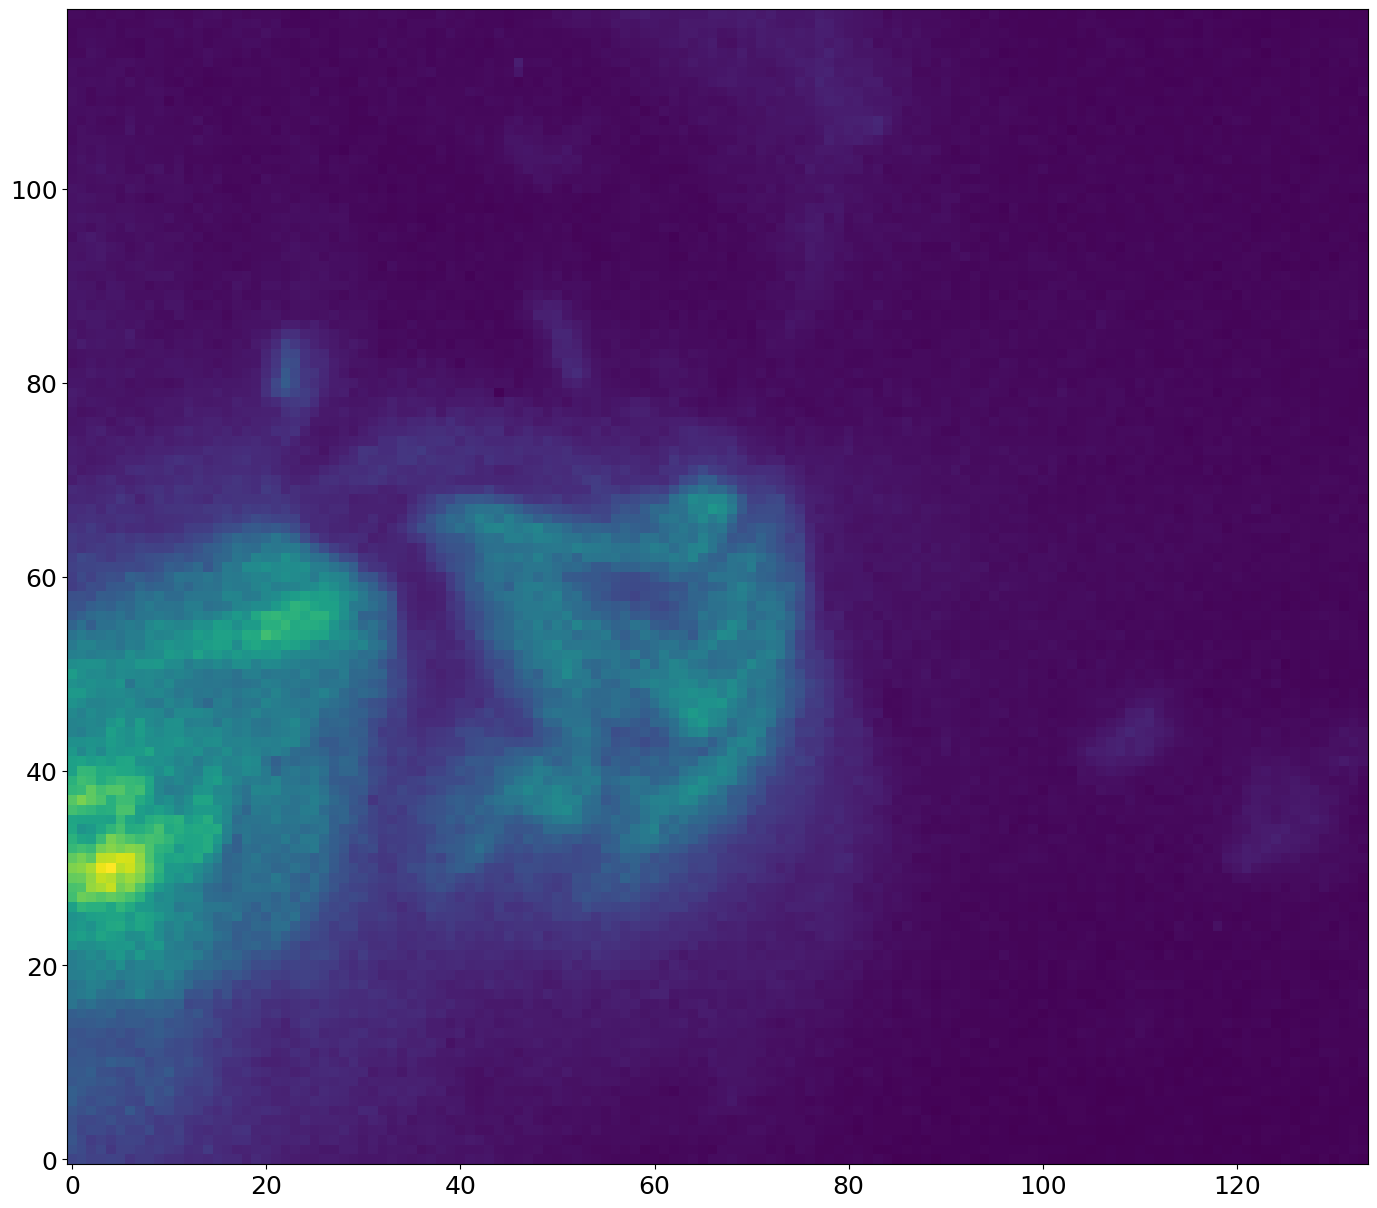

In [10]:
plt.imshow(xrtmaps[0].data)

[Text(0.5, 1.0, 'AIA 94 Temperature Response'),
 Text(0.5, 0, 'Temperature (dB Kelvin)'),
 Text(0, 0.5, 'Response (DN/s/(cm$^{-3})^2$/Mm)')]

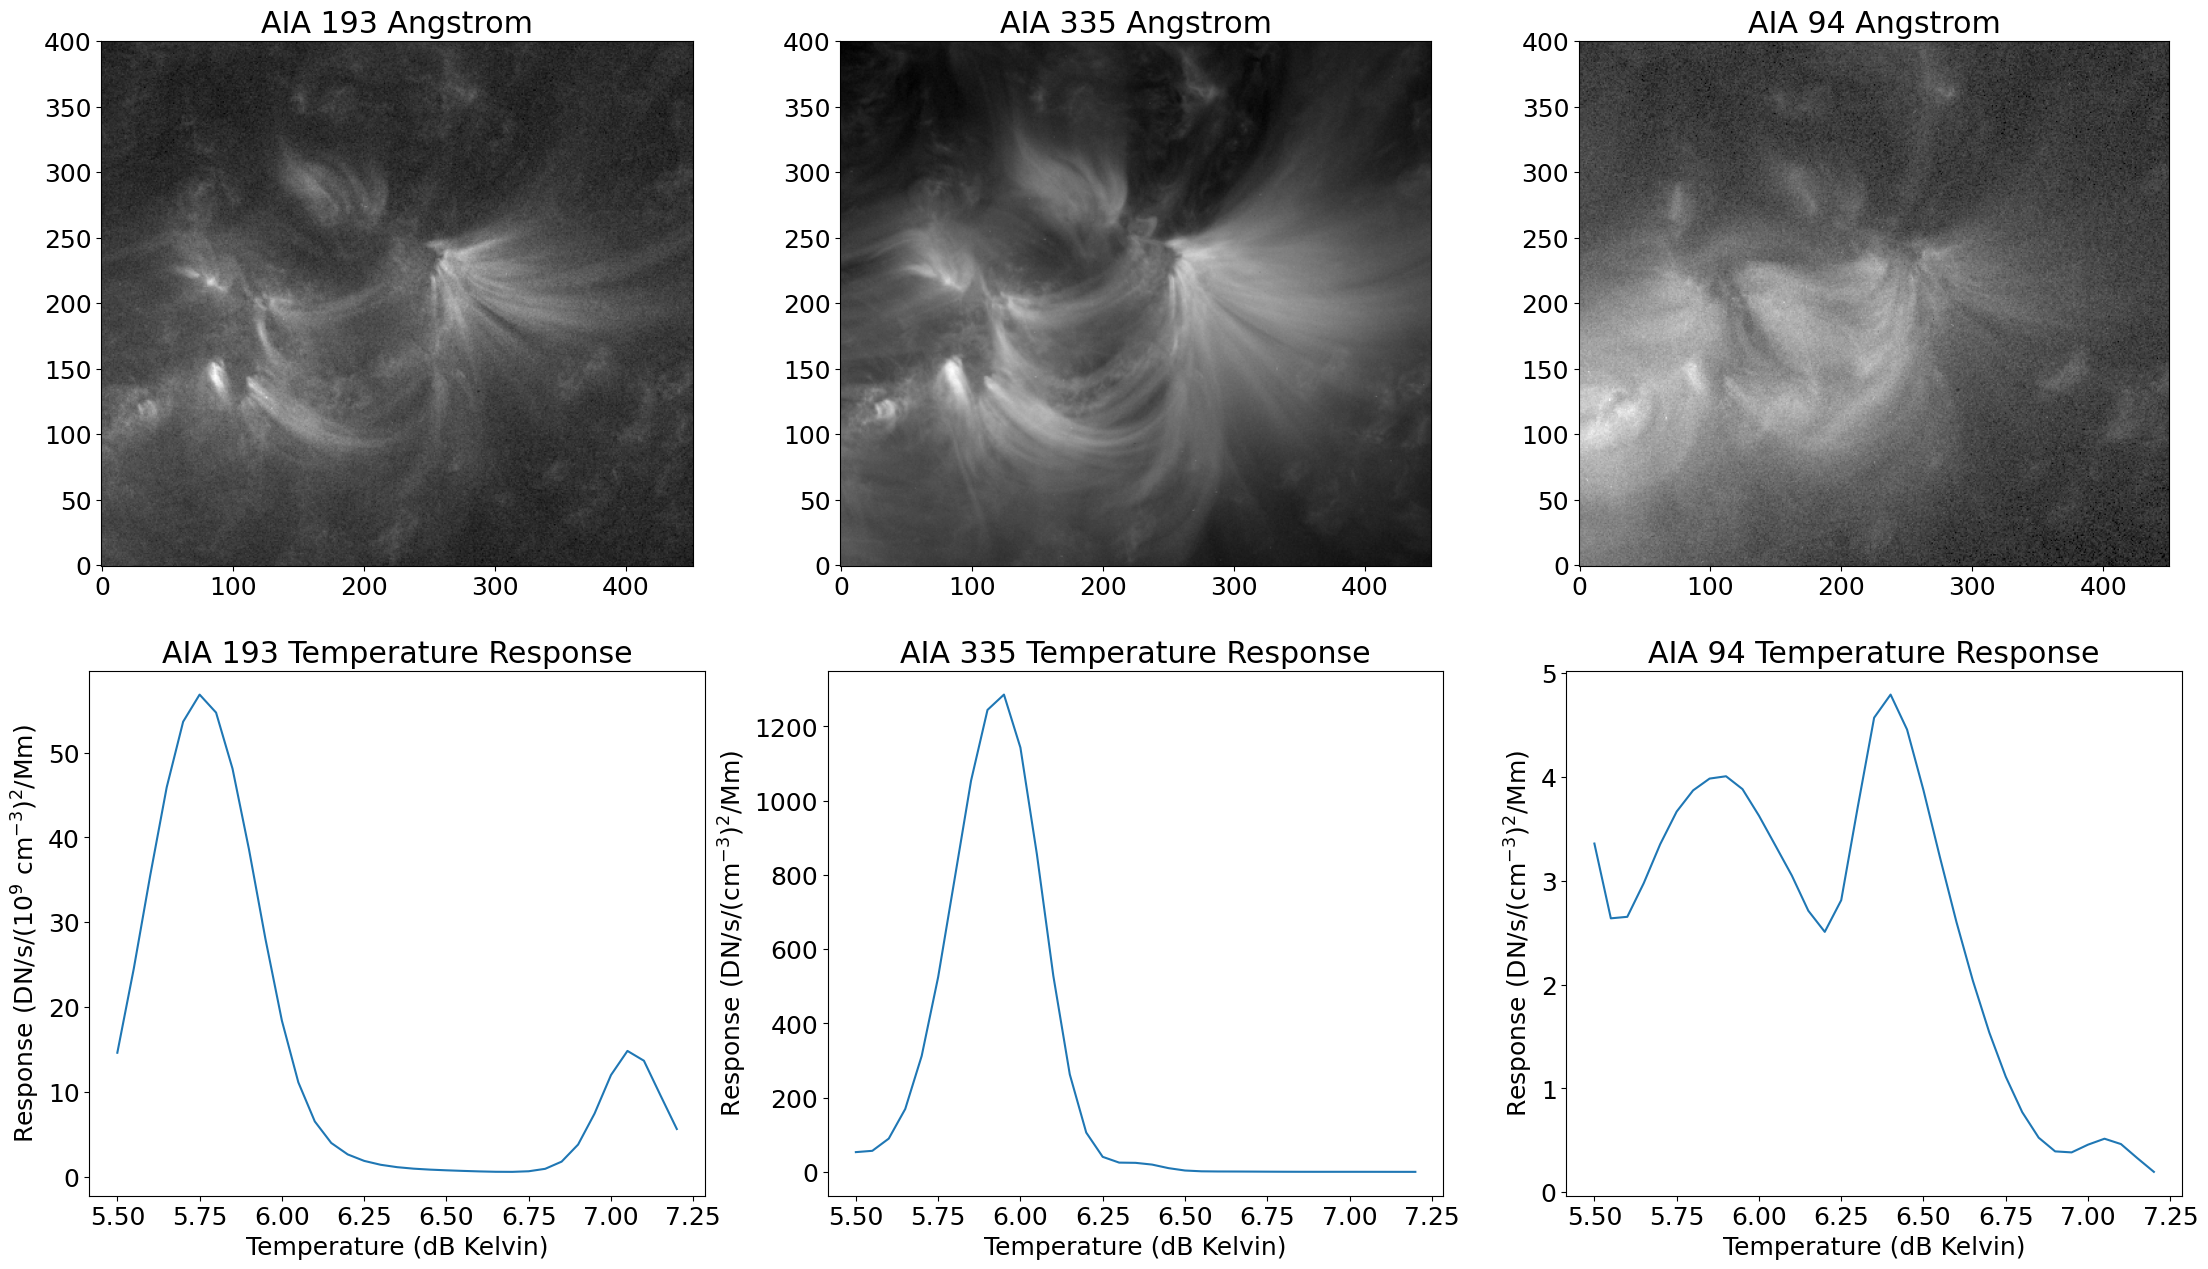

In [12]:
# Show some of the AIA channels and their temperature responses for illustration:
plt_emmax = 5.0e28
gfac = 1.0/2.2

fig, axs = plt.subplots(2, 3)
axs[0,0].imshow(np.clip(maps[1].data/np.max(tresps[1]),0,plt_emmax)**gfac,cmap=plt.get_cmap('gray'))
axs[0,0].set(title='AIA 193 Angstrom')
axs[1,0].plot(trlogts[1],tresps[1]/1.0e-27)
axs[1,0].set(title='AIA 193 Temperature Response',xlabel='Temperature (dB Kelvin)',ylabel='Response (DN/s/(10$^9$ cm$^{-3})^2$/Mm)')

axs[0,1].imshow(np.clip(maps[2].data/np.max(tresps[2]),0,plt_emmax)**gfac,cmap=plt.get_cmap('gray'))
axs[0,1].set(title='AIA 335 Angstrom')
axs[1,1].plot(trlogts[2],tresps[2]/1.0e-27)
axs[1,1].set(title='AIA 335 Temperature Response',xlabel='Temperature (dB Kelvin)',ylabel='Response (DN/s/(cm$^{-3})^2$/Mm)')

axs[0,2].imshow(np.clip(maps[5].data/np.max(tresps[5]),0,plt_emmax)**gfac,cmap=plt.get_cmap('gray'))
axs[0,2].set(title='AIA 94 Angstrom')
axs[1,2].plot(trlogts[5],tresps[5]/1.0e-27)
axs[1,2].set(title='AIA 94 Temperature Response',xlabel='Temperature (dB Kelvin)',ylabel='Response (DN/s/(cm$^{-3})^2$/Mm)')

In [13]:
import EMToolKit.algorithms.sparse_nlmap_solver
importlib.reload(EMToolKit.algorithms.sparse_nlmap_solver)

<module 'EMToolKit.algorithms.sparse_nlmap_solver' from '/home/jplowman/research/solar-physics/testing/EMToolKit/EMToolKit/algorithms/sparse_nlmap_solver.py'>

In [14]:
multi_coeffs, multi_logts, multi_bases, multi_coords, multi_algorithm, multi_em_wrapper = sparse_nlmap_dem_wrapper(datasequence, 
                                                                                                                   wrapargs={'norms':norms, 'overall_norm':overall_norm})

100%|█████████████████████████████████████████████████████████████████████| 193390/193390 [01:13<00:00, 2615.74it/s]


69431.25898973951 1076.9306258570148 0.0 2.8913682762772446 [np.uint64(1101905), 6768650]
Overall regularization factor: 1.0
float32 float32 float32 float32 float32
51.53 s i = 0 chi2 = 93.02 step size = 0.3 reg. param. = 0.12 chi2 change = 95.28609 reg. change = -0.12086
Setup:  0.4575343132019043 Solver:  48.6575026512146 Stepper:  2.4135053157806396
New combined FOM: 93.1406275465657 Old combined FOM: 188.3058593980425 Change: 95.16523185147679
float32 float32 float32 float32 float32
198.81 s i = 1 chi2 = 20.24 step size = 0.85 reg. param. = 0.47 chi2 change = 72.77576 reg. change = -0.35413
Setup:  0.9451045989990234 Solver:  193.01921701431274 Stepper:  4.843346118927002
New combined FOM: 20.718993123061637 Old combined FOM: 93.1406275465657 Change: 72.42163442350406
float32 float32 float32 float32 float32
385.12 s i = 2 chi2 = 3.77 step size = 0.85 reg. param. = 0.67 chi2 change = 16.47657 reg. change = -0.19304
Setup:  1.4177908897399902 Solver:  375.88563084602356 Stepper:  7.8

In [15]:
multi_em_demsequence = emtk.dem_model(multi_coeffs, multi_logts, multi_bases, multi_coords, multi_algorithm, multi_em_wrapper) 
em_collection.add_model(multi_em_demsequence)

In [16]:
multi_synthmaps = [em_collection.synthesize_map(map) for map in em_collection.data()]
multi_synthdata = [map for map in multi_synthmaps]

NameError: name 'multi_resids' is not defined

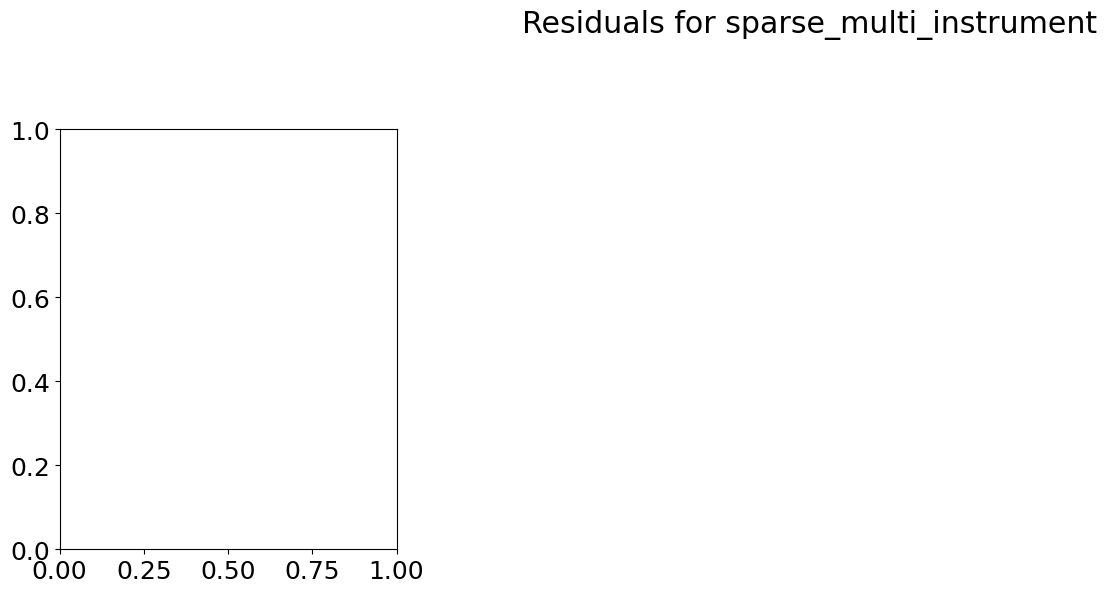

In [17]:
# Plot Residuals:
fig = plt.figure(figsize=[20,12])
plt.suptitle('Residuals for '+multi_algorithm)
for i in range(0,7):
    ax1 = fig.add_subplot(2,4,i+1)
    ax1.imshow(multi_resids[i],vmin=0,vmax=5)
    ax1.set(title=em_collection.data()[i].meta['channel'])

In [18]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


class dashboard_object(object):
    def __init__(self,em_collection):
        self.emc = em_collection
        
    def widgwrap(self, xpt, ypt, rtemp, gtemp, btemp, sigma, algorithm):
        dashboard_figure(self.emc, plotpoint=[xpt,ypt], temperatures=[rtemp,gtemp,btemp], sigmas=sigma, algorithm=algorithm)

In [19]:
importlib.reload(EMToolKit.visualization.dashboard)
from EMToolKit.visualization.dashboard import dashboard_figure
dash = dashboard_object(em_collection)

ImportError: cannot import name 'dashboard_figure' from 'EMToolKit.visualization.dashboard' (/home/jplowman/research/solar-physics/testing/EMToolKit/EMToolKit/visualization/dashboard.py)

In [20]:
[nx,ny] = dash.emc.collection[dash.emc.collection['models'][0]][0].data.shape
xpt=widgets.IntSlider(min=0, max=nx, value=10, step=1, description='xpt', continuous_update=False) 
ypt=widgets.IntSlider(min=0, max=ny, value=100, step=1, description='ypt', continuous_update=False)
rtemp=widgets.FloatSlider(min=5, max=7, value=5.8, step=0.05, description='rtemp', continuous_update=False)
gtemp=widgets.FloatSlider(min=5, max=7, value=6.1, step=0.05, description='gtemp', continuous_update=False)
btemp=widgets.FloatSlider(min=5, max=7, value=6.4, step=0.05, description='btemp', continuous_update=False)
sigma=widgets.FloatSlider(min=0.025, max=0.5, value=0.125, step=0.01, description='sigma', continuous_update=False)
algorithm=widgets.Dropdown(options=dash.emc.collection['models'], description='algorithm', continuous_update=False)
ui = widgets.HBox([xpt,ypt,rtemp,gtemp,btemp,sigma,algorithm])
out = widgets.interactive_output(dash.widgwrap, {'xpt':xpt,'ypt':ypt,'rtemp':rtemp,'gtemp':gtemp,'btemp':btemp,'sigma':sigma,'algorithm':algorithm})
display(ui,out)

NameError: name 'dash' is not defined